In [1]:
from pyspark.sql import SparkSession
import os
from search import Search
from plotting import Plotting

os.environ["PYTHONUNBUFFERED"] = "1"
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"


Bad key "text.kerning_factor" on line 4 in
E:\Users\Sam\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def read(spark):
    datasets = {}
    for dataset in os.listdir("./ml-latest-small"):
        data = spark.read.option("header", True).format("csv").load(os.path.join(os.getcwd(),"ml-latest-small",dataset))
        datasets[dataset.split('.')[0]]=data
    return datasets

In [3]:
spark = SparkSession.builder.master("local").appName("Movies").config("conf-key", "conf-value").getOrCreate()
datasets = read(spark)

In [4]:
plotting = Plotting(datasets, spark)
search = Search(datasets, spark)

Search user by id, show the number of movies/genre that he/she has watched

In [5]:
search.search_user_movies('1')

232

In [6]:
search.search_user_genre('1').show()

+---------+--------+
|   genres|count(1)|
+---------+--------+
|    Crime|      45|
|  Romance|      26|
| Thriller|      55|
|Adventure|      85|
|    Drama|      68|
|      War|      22|
|  Fantasy|      47|
|  Mystery|      18|
|  Musical|      22|
|Animation|      29|
|Film-Noir|       1|
|   Horror|      17|
|  Western|       7|
|   Comedy|      83|
| Children|      42|
|   Action|      90|
|   Sci-Fi|      40|
+---------+--------+



Given a list of users, search all movies watched by each user

In [7]:
[i for i in search.search_users_movies(["1","2","3"])]

[232, 29, 39]

Search movie by id/title, show the average rating, the number of users that have
watched the movie

In [8]:
search.search_movie(id="1").show()

+-------+-----------------+--------+----------------+
|movieId|      avg(rating)|count(1)|           title|
+-------+-----------------+--------+----------------+
|      1|3.813953488372093|     215|Toy Story (1995)|
+-------+-----------------+--------+----------------+



In [9]:
search.search_movie(name="Toy Story").show()

+-------+-----------------+--------+------------------+
|movieId|      avg(rating)|count(1)|             title|
+-------+-----------------+--------+------------------+
|   3114|3.711340206185567|      97|Toy Story 2 (1999)|
|      1|3.813953488372093|     215|  Toy Story (1995)|
|  78499|3.981818181818182|      55|Toy Story 3 (2010)|
+-------+-----------------+--------+------------------+



Search genre, show all movies in that genre

In [10]:
search.search_genre("Action").show(10,False)

+-------+-----------------------------------------+----------------------------------+
|movieId|title                                    |genres                            |
+-------+-----------------------------------------+----------------------------------+
|6      |Heat (1995)                              |Action|Crime|Thriller             |
|9      |Sudden Death (1995)                      |Action                            |
|10     |GoldenEye (1995)                         |Action|Adventure|Thriller         |
|15     |Cutthroat Island (1995)                  |Action|Adventure|Romance          |
|20     |Money Train (1995)                       |Action|Comedy|Crime|Drama|Thriller|
|23     |Assassins (1995)                         |Action|Crime|Thriller             |
|42     |Dead Presidents (1995)                   |Action|Crime|Drama                |
|44     |Mortal Kombat (1995)                     |Action|Adventure|Fantasy          |
|66     |Lawnmower Man 2: Beyond Cyberspace

Given a list of genres, search all movies belonging to each genre

In [19]:
[i.show(3, False) for i in search.search_genres(["Action","Romance"])]

+-------+-------------------+-------------------------+
|movieId|title              |genres                   |
+-------+-------------------+-------------------------+
|6      |Heat (1995)        |Action|Crime|Thriller    |
|9      |Sudden Death (1995)|Action                   |
|10     |GoldenEye (1995)   |Action|Adventure|Thriller|
+-------+-------------------+-------------------------+
only showing top 3 rows

+-------+------------------------+--------------------+
|movieId|title                   |genres              |
+-------+------------------------+--------------------+
|3      |Grumpier Old Men (1995) |Comedy|Romance      |
|4      |Waiting to Exhale (1995)|Comedy|Drama|Romance|
|7      |Sabrina (1995)          |Comedy|Romance      |
+-------+------------------------+--------------------+
only showing top 3 rows



[None, None]

Search movies by year

In [12]:
search.search_movie_year("1995").show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

List the top n movies with highest rating, ordered by the rating

In [21]:
search.list_rating(5).show(truncate=False)

+-------+-----------+-------+---------------------------------------------------------------------------------+---------------+
|movieId|avg(rating)|watched|title                                                                            |genres         |
+-------+-----------+-------+---------------------------------------------------------------------------------+---------------+
|99     |5.0        |2      |Heidi Fleiss: Hollywood Madam (1995)                                             |Documentary    |
|6442   |5.0        |2      |Belle époque (1992)                                                              |Comedy|Romance |
|78836  |5.0        |2      |Enter the Void (2009)                                                            |Drama          |
|3473   |5.0        |2      |Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976)|Comedy         |
|53     |5.0        |2      |Lamerica (1994)                                                            

List the top n movies with the highest number of watches, ordered by the number of
watches

In [22]:
search.list_watches(5).show(truncate=False)

+-------+-------+--------------------------------+---------------------------+
|movieId|watches|title                           |genres                     |
+-------+-------+--------------------------------+---------------------------+
|356    |329    |Forrest Gump (1994)             |Comedy|Drama|Romance|War   |
|318    |317    |Shawshank Redemption, The (1994)|Crime|Drama                |
|296    |307    |Pulp Fiction (1994)             |Comedy|Crime|Drama|Thriller|
|593    |279    |Silence of the Lambs, The (1991)|Crime|Horror|Thriller      |
|2571   |278    |Matrix, The (1999)              |Action|Sci-Fi|Thriller     |
+-------+-------+--------------------------------+---------------------------+



Find the favourite genre of a given user, or group of users. Consider and justify how
you will define ‘favourite’.

In [15]:
search.search_user_favourites("1").show(10,False)

+---------+------------------+
|genres   |score             |
+---------+------------------+
|Action   |4.322222222222222 |
|Adventure|4.142494117647059 |
|Comedy   |3.9392168674698795|
|Drama    |3.410647058823529 |
|Thriller |2.516290909090909 |
|Fantasy  |2.222             |
|Crime    |2.151644444444444 |
|Children |2.096452380952381 |
|Sci-Fi   |1.85055           |
|Animation|1.4772413793103447|
+---------+------------------+
only showing top 10 rows



Compare the movie tastes of two users. Consider and justify how you will compare
and present the data.

In [16]:
#TODO

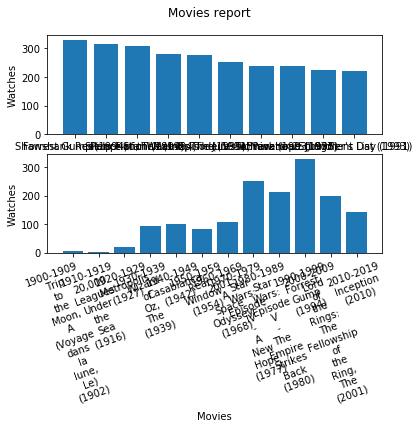

In [6]:
plotting.gen_movies_report()

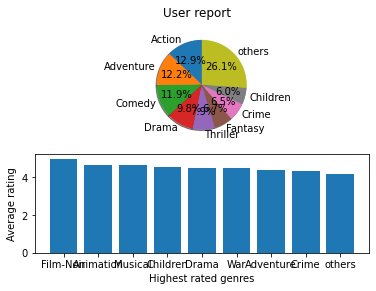

In [18]:
plotting.gen_user_report("1")

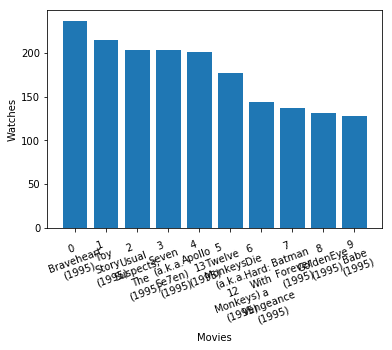

In [5]:
plotting.gen_most_watched_year("1995", 10)

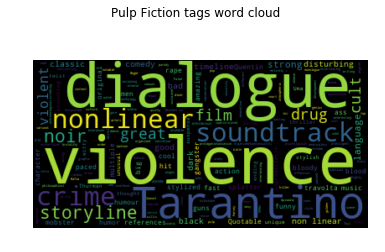

In [9]:
plotting.gen_movie_wordcloud("Pulp Fiction")